In [121]:
import numpy as np
import pandas as pd
import scipy
import scipy.interpolate as interp
import scipy.optimize as opt

In [122]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', font_scale=1.5)
mpl.rcParams['figure.figsize'] = (8, 6)
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']

In [123]:
# parameters
rho = 0.05 # discount rate
alpha = 0.3 # capital elasticity
delta = 0.1 # depreciation
theta = 1.0 # crra param

## Ramsey Model

In [124]:
# algorithm
S0 = 2**16 # max number of steps in perturbation simulation
S1 = 4096 # short simulation
K = 512 # size of capital grid
ptol = 1.0e-4 # initial displacement for perturbation simulation
dt_max = 1.0 # max time step in variable delt schemes

In [126]:
# steady state
k_ss = (alpha/(rho+delta))**(1.0/(1.0-alpha))
i_ss = delta*k_ss
y_ss = k_ss**alpha
c_ss = y_ss - i_ss

In [89]:
def simulate_ramsey(k0, c0, k_lo=0, k_hi=None, gk_targ=0.001, dt=None, S=S0, direc=-1):
    # initial values
    k, c = k0, c0
    kpath, cpath = [k], [c]

    for t in range(S):
        # growth rates
        gk = k**(alpha-1) - delta - c/k
        gc = (1/theta)*(alpha*k**(alpha-1)-(rho+delta))

        # adaptive step size
        dt1 = direc*np.minimum(dt_max, gk_targ/np.abs(gk)) if dt is None else dt
        k *= 1 + dt1*gk
        c *= 1 + dt1*gc

        # store
        kpath.append(k)
        cpath.append(c)

        # terminal condition
        if k_lo is not None and k <= k_lo:
            break
        if k_hi is not None and k >= k_hi:
            break

    return np.array(kpath), np.array(cpath)

In [95]:
# capital grid around steady state
k_lo, k_hi = 0.01, 2.0*k_ss

# generate upper and lower paths
kvec1, cvec1 = simulate_ramsey(k_ss-ptol, c_ss-ptol, k_lo, k_hi)
kvec2, cvec2 = simulate_ramsey(k_ss+ptol, c_ss+ptol, k_lo, k_hi)

# combined path
kvec = np.concatenate([kvec1[::-1], kvec2])
cvec = np.concatenate([cvec1[::-1], cvec2])

# interpolate
cpol = interp.interp1d(kvec, cvec)

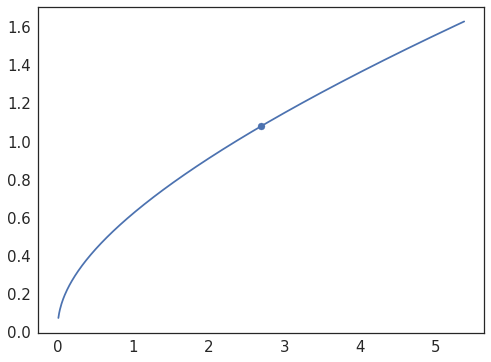

In [97]:
k_grid = np.linspace(k_lo, k_hi, K)
c_grid = cpol(k_grid)

# plot results
fig, ax = plt.subplots()
ax.plot(k_grid, c_grid);
ax.scatter([k_ss], [c_ss]);

In [98]:
def forward_ramsey(k0, cf, dt=0.01, S=S0):
    # initial values
    k, c = k0, cf(k0)
    kpath, cpath = [k], [c]

    for t in range(S):
        gk = k**(alpha-1) - delta - c/k

        k *= 1 + dt*gk
        c = cf(k)

        # store
        kpath.append(k)
        cpath.append(c)

    return np.array(kpath), np.array(cpath)

In [99]:
def solow_policy(s):
    return lambda k: (1-s)*k**alpha

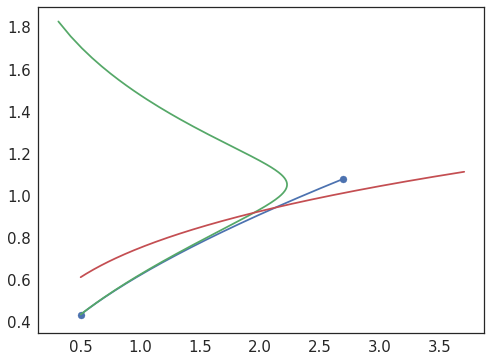

In [104]:
k0 = 0.5
c0 = float(cpol(k0))

csol = solow_policy(0.25)

dt = 0.1
kfwd, cfwd = forward_ramsey(k0, cpol, dt=dt, S=S1)
ksol, csol = forward_ramsey(k0, csol, dt=dt, S=S1)
ksim, csim = simulate_ramsey(k0, c0, dt=dt, k_lo=0.4, direc=1)

fig, ax = plt.subplots()
ax.plot(kfwd, cfwd);
ax.plot(ksim, csim);
ax.plot(ksol, csol);
ax.scatter([k0, k_ss], [c0, c_ss]);

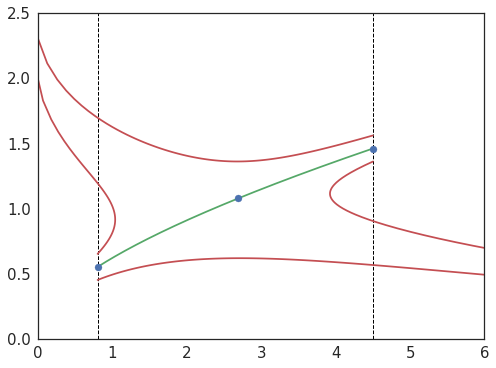

In [127]:
kv0 = [0.8, 4.5]
cv0 = cpol(kv0)
dt = 0.1
err = 0.1

fig, ax = plt.subplots()

for k0, c0 in zip(kv0, cv0):
    kfwd, cfwd = forward_ramsey(k0, cpol, dt=dt, S=S1)
    ksim1, csim1 = simulate_ramsey(k0, c0-err, dt=dt, k_hi=6.0, S=S1, direc=1)
    ksim2, csim2 = simulate_ramsey(k0, c0+err, dt=dt, k_hi=6.0, S=S1, direc=1)

    ax.plot(kfwd, cfwd, color=col[1]);
    ax.plot(ksim1, csim1, color=col[2]);
    ax.plot(ksim2, csim2, color=col[2]);
    ax.vlines(k0, 0, 2.5, color='k', linestyle='--', linewidth=1);
    
ax.scatter(kv0, cv0, color=col[0], zorder=3);
ax.scatter([k_ss], [c_ss], color=col[0], zorder=3);
ax.set_xlim(0, 6);
ax.set_ylim(0, 2.5);

Now try a policy change?

## Value Functions